In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam , AdamW
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import os
import numpy as np
from sklearn.utils import class_weight


In [6]:
image_path ='/kaggle/input/dataset1/editData/image'
mask_path = '/kaggle/input/dataset1/editData/mask'

In [7]:
import os
import tensorflow as tf

def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)  # Convert mask to single channel

    return img, mask

def preprocess(image, mask):
    image = tf.image.resize(image, (256, 256), method='nearest')  # Resize to 256x256
    mask = tf.image.resize(mask, (256, 256), method='nearest')  #  using nearest 
    return image, mask

# images and masks are sorted in order
image_list = sorted([os.path.join(image_path, i) for i in os.listdir(image_path)])
mask_list = sorted([os.path.join(mask_path, i) for i in os.listdir(mask_path)])

# Create dataset
image_list_ds = tf.data.Dataset.from_tensor_slices(image_list)
mask_list_ds = tf.data.Dataset.from_tensor_slices(mask_list)

# Zip datasets to get pairs of (image_path, mask_path)
dataset = tf.data.Dataset.zip((image_list_ds, mask_list_ds))

# Apply processing and preprocessing
processed_image_ds = dataset.map(process_path).map(preprocess)


def count_elements(dataset):
    return sum(1 for _ in dataset)

# 80% train, 10% validation, 10% test
BUFFER_SIZE = 500
def split_dataset(dataset, train_size=0.8, val_size=0.1, test_size=0.1):
    dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)
    total_size = count_elements(dataset)
    train_size = int(total_size * train_size)
    val_size = int(total_size * val_size)
    test_size = int(total_size * test_size)
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(processed_image_ds)

# Prepare datasets
BATCH_SIZE = 16
def prepare_dataset(dataset, batch_size):
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = prepare_dataset(train_ds, BATCH_SIZE)
val_dataset = prepare_dataset(val_ds, BATCH_SIZE)
test_dataset = prepare_dataset(test_ds, BATCH_SIZE)


#def augment(image, mask):
 #   if tf.random.uniform(()) > 0.5:
  #      # Random flipping of the image and mask
   #     image = tf.image.flip_left_right(image)
    #    mask = tf.image.flip_left_right(mask)
    #return image, mask

def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        # flip horizontally
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        # flip vertically
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    if tf.random.uniform(()) > 0.5:
        # rotate by 90 degrees
        image = tf.image.rot90(image)
        mask = tf.image.rot90(mask)

    return image, mask

# Apply augmentation on training dataset
train_dataset = train_dataset.map(lambda image, mask: augment(image, mask))

# Check shapes of the datasets
def print_shapes(dataset, num_batches=1):
    for images, masks in dataset.take(num_batches):
        print(f"Images shape: {images.shape}, Masks shape: {masks.shape}")
        break  # Exit after the first batch

print("Train Dataset:")
print_shapes(train_dataset)

print("\nValidation Dataset:")
print_shapes(val_dataset)

print("\nTest Dataset:")
print_shapes(test_dataset)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6
)

Train Dataset:
Images shape: (16, 256, 256, 3), Masks shape: (16, 256, 256, 1)

Validation Dataset:
Images shape: (16, 256, 256, 3), Masks shape: (16, 256, 256, 1)

Test Dataset:
Images shape: (16, 256, 256, 3), Masks shape: (16, 256, 256, 1)


Sample 1:
Image shape: (256, 256, 3)
Mask unique values: [0 1]


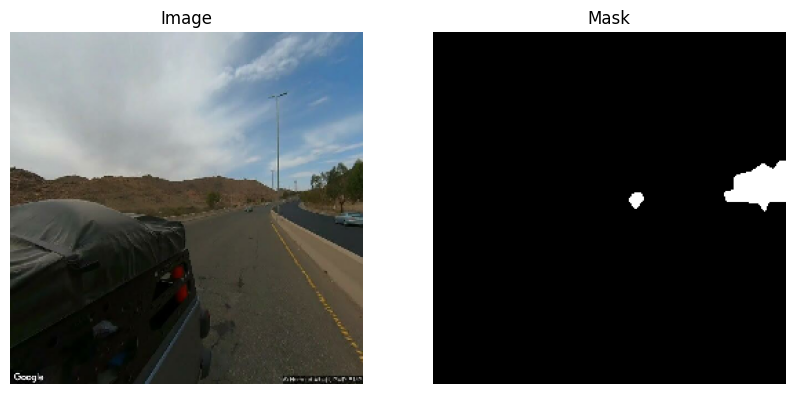

Sample 2:
Image shape: (256, 256, 3)
Mask unique values: [0 1]


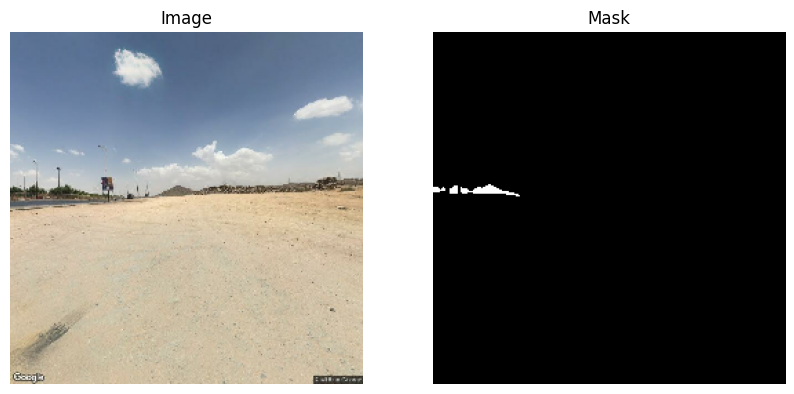

Sample 3:
Image shape: (256, 256, 3)
Mask unique values: [0 1]


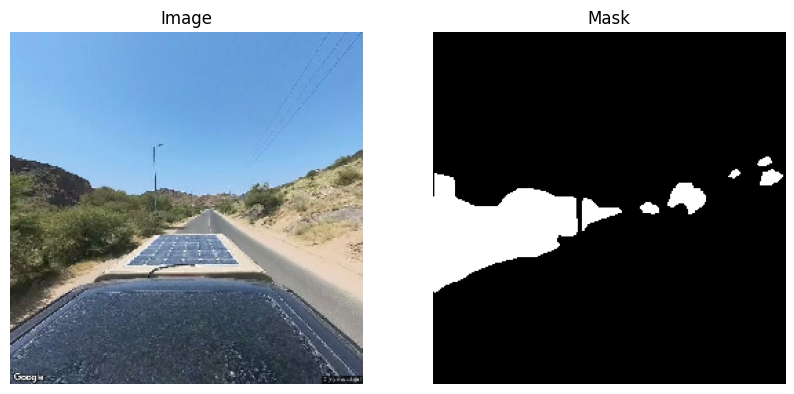

Sample 4:
Image shape: (256, 256, 3)
Mask unique values: [0 1]


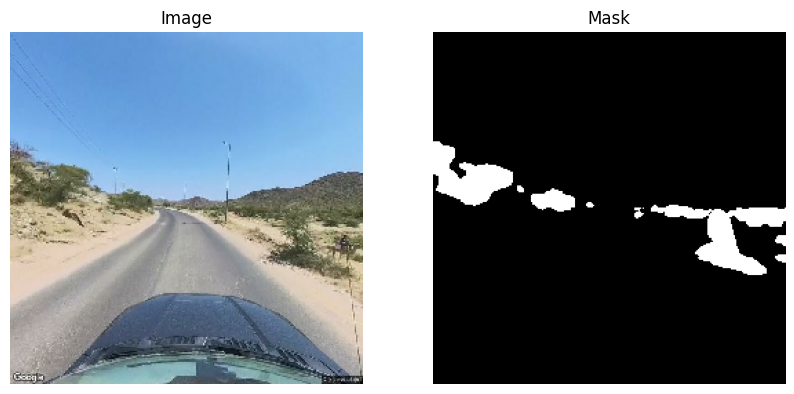

Sample 5:
Image shape: (256, 256, 3)
Mask unique values: [0 1]


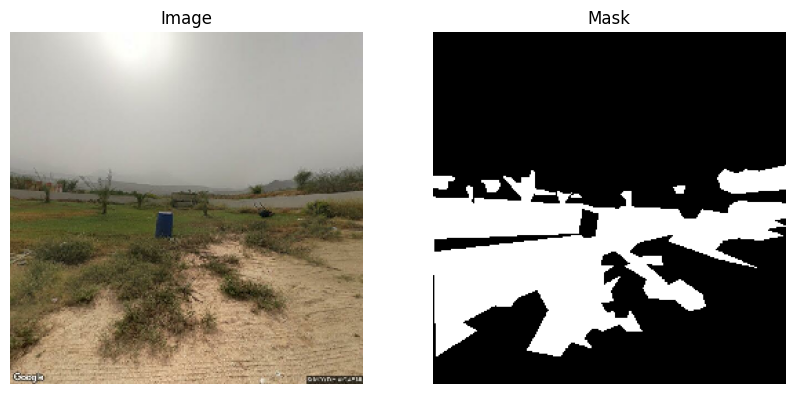

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# to visualize sample from the dataset
def visualize_sample(image, mask):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

def visual_dataset(dataset, num_samples=5):
    sample_images = []
    sample_masks = []
    for image, mask in dataset.take(num_samples):
        sample_images.append(image.numpy())
        sample_masks.append(mask.numpy())
    
    # Visualize the samples
    for i in range(num_samples):
        print(f"Sample {i + 1}:")
        print("Image shape:", sample_images[i].shape)
        print("Mask unique values:", np.unique(sample_masks[i]))
        visualize_sample(sample_images[i], sample_masks[i])

# Call the inspect function on your dataset
visual_dataset(train_ds)


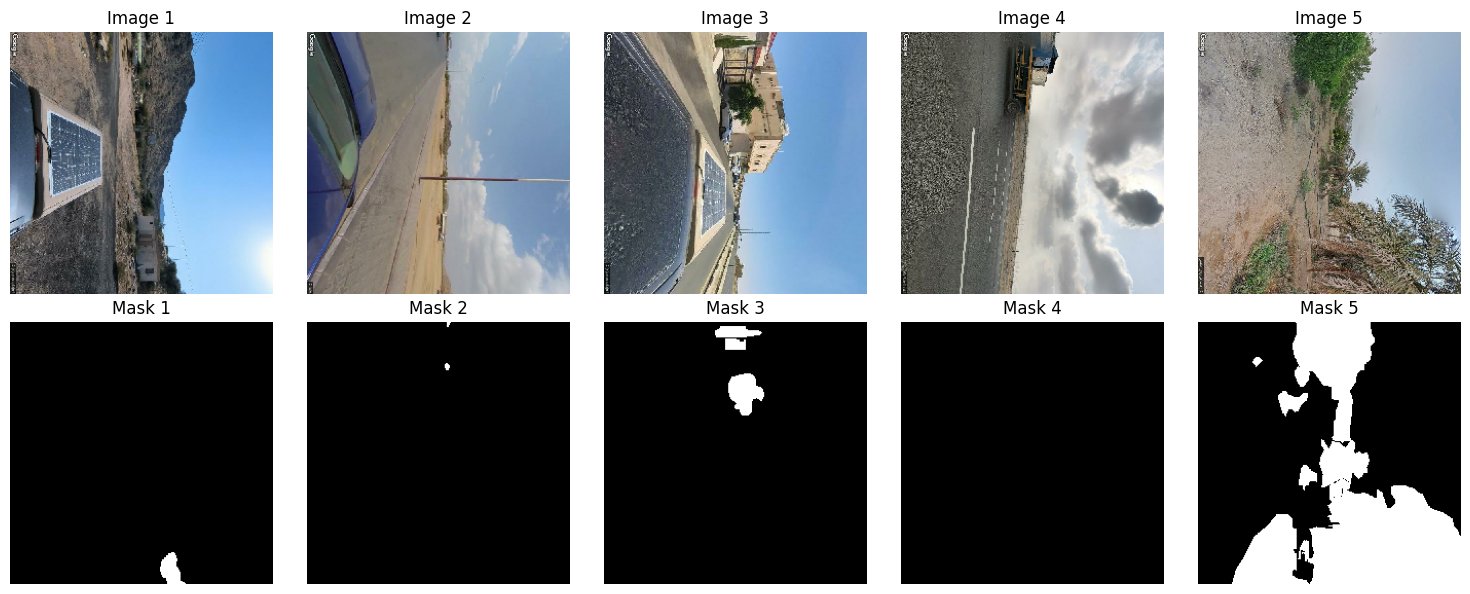

In [9]:
import matplotlib.pyplot as plt
# visualize for training 
def visualize_subset(train_dataset, num_samples=5):
    plt.figure(figsize=(15, 6))
    
    for i, (img_batch, mask_batch) in enumerate(train_dataset.take(1)):  # one batch
        for j in range(num_samples):
            
            img = img_batch[j].numpy()
            mask = mask_batch[j].numpy()

            plt.subplot(2, num_samples, j + 1)
            plt.title(f"Image {j + 1}")
            plt.imshow(img)  # Display the image
            plt.axis('off')
            
            plt.subplot(2, num_samples, num_samples + j + 1)
            plt.title(f"Mask {j + 1}")
            plt.imshow(mask.squeeze(), cmap='gray')  # Display the mask
            plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_subset(train_dataset, num_samples=5)

In [10]:
#for handling class imbalance

def extract_labels(dataset):
    all_masks = []
    for images, masks in dataset:
        all_masks.append(masks.numpy())  
    return np.concatenate(all_masks, axis=0).flatten()  


y_train = extract_labels(train_dataset)

class_labels = np.unique(y_train)

weights = class_weight.compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)

class_weight_dict = {i: weights[i] for i in range(len(weights))}
print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.527771472630718, 1: 9.502043331453544}


In [11]:
#define metices
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import BinaryCrossentropy


def dice_coef(y_true, y_pred, smooth=1):
    # Ensure both y_true and y_pred are float32
    y_true_f = K.cast(K.flatten(y_true), tf.float32)
    y_pred_f = K.cast(K.flatten(y_pred), tf.float32)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)  # Convert to float32
    y_pred_f = tf.reshape(y_pred, [-1]) 
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou
import tensorflow as tf

def dice_loss(y_true, y_pred, smooth=1e-6):
    """    
    Parameters:
    - y_true: Ground truth labels.
    - y_pred: Predicted labels.
    - smooth: A smoothing factor to avoid division by zero.

    """
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice_coeff = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    
    return 1 - dice_coeff  

def combined_loss(y_true, y_pred):
    return 0.5 * BinaryCrossentropy()(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Convolution2D, BatchNormalization, LeakyReLU, Add, 
                                     ReLU, GlobalAveragePooling2D, UpSampling2D, AveragePooling2D, 
                                     Activation, Dropout, concatenate)
from tensorflow.keras.regularizers import l2

def convolutional_block(input_tensor, filters, block_identifier, dropout_rate=0.2, l2_lambda=0.1):
    # Dilated convolution block
    block_name = 'block_' + str(block_identifier) + '_'
    filter1, filter2, filter3 = filters
    skip_connection = input_tensor

    # Block A
    input_tensor = Convolution2D(filters=filter1, kernel_size=(1, 1), dilation_rate=(1, 1),
                                 padding='same', kernel_initializer='he_normal',
                                 kernel_regularizer=l2(l2_lambda),  # Corrected to kernel_regularizer
                                 name=block_name + 'a')(input_tensor)
    input_tensor = BatchNormalization(name=block_name + 'batch_norm_a')(input_tensor)
    input_tensor = LeakyReLU(negative_slope=0.2, name=block_name + 'leakyrelu_a')(input_tensor)
    input_tensor = Dropout(dropout_rate, name=block_name + 'dropout_a')(input_tensor)

    # Block B
    input_tensor = Convolution2D(filters=filter2, kernel_size=(3, 3), dilation_rate=(2, 2),
                                 padding='same', kernel_initializer='he_normal',
                                 kernel_regularizer=l2(l2_lambda),  # Corrected to kernel_regularizer
                                 name=block_name + 'b')(input_tensor)
    input_tensor = BatchNormalization(name=block_name + 'batch_norm_b')(input_tensor)
    input_tensor = LeakyReLU(negative_slope=0.2, name=block_name + 'leakyrelu_b')(input_tensor)
    input_tensor = Dropout(dropout_rate, name=block_name + 'dropout_b')(input_tensor)

    # Block C
    input_tensor = Convolution2D(filters=filter3, kernel_size=(1, 1), dilation_rate=(1, 1),
                                 padding='same', kernel_initializer='he_normal', 
                                 kernel_regularizer=l2(l2_lambda),  # Corrected to kernel_regularizer
                                 name=block_name + 'c')(input_tensor)
    input_tensor = BatchNormalization(name=block_name + 'batch_norm_c')(input_tensor)

    # Skip convolutional block for residual connection
    skip_connection = Convolution2D(filters=filter3, kernel_size=(3, 3), padding='same',
                                    name=block_name + 'skip_conv')(skip_connection)
    skip_connection = BatchNormalization(name=block_name + 'batch_norm_skip_conv')(skip_connection)

    # Block C + Skip Convolution
    input_tensor = Add(name=block_name + 'add')([input_tensor, skip_connection])
    input_tensor = ReLU(name=block_name + 'relu')(input_tensor)

    return input_tensor

def base_convolutional_block(input_layer, dropout_rate=0.2, l2_lambda=0.1):
    # Base convolutional block to obtain input image feature maps

    # Base Block 1
    base_result = convolutional_block(input_layer, [32, 32, 64], '1', dropout_rate=dropout_rate, l2_lambda=l2_lambda)

    # Base Block 2
    base_result = convolutional_block(base_result, [64, 64, 128], '2', dropout_rate=dropout_rate, l2_lambda=l2_lambda)

    # Base Block 3
    base_result = convolutional_block(base_result, [128, 128, 256], '3', dropout_rate=dropout_rate, l2_lambda=l2_lambda)

    return base_result

def pyramid_pooling_module(input_layer):
    # Pyramid pooling module
    base_result = base_convolutional_block(input_layer)

    # Red Pixel Pooling
    red_result = GlobalAveragePooling2D(name='red_pool')(base_result)
    red_result = tf.keras.layers.Reshape((1, 1, 256))(red_result)
    red_result = Convolution2D(filters=64, kernel_size=(1, 1), name='red_1_by_1')(red_result)
    red_result = UpSampling2D(size=256, interpolation='bilinear', name='red_upsampling')(red_result)

    # Yellow Pixel Pooling
    yellow_result = AveragePooling2D(pool_size=(2, 2), name='yellow_pool')(base_result)
    yellow_result = Convolution2D(filters=64, kernel_size=(1, 1), name='yellow_1_by_1')(yellow_result)
    yellow_result = UpSampling2D(size=2, interpolation='bilinear', name='yellow_upsampling')(yellow_result)

    # Blue Pixel Pooling
    blue_result = AveragePooling2D(pool_size=(4, 4), name='blue_pool')(base_result)
    blue_result = Convolution2D(filters=64, kernel_size=(1, 1), name='blue_1_by_1')(blue_result)
    blue_result = UpSampling2D(size=4, interpolation='bilinear', name='blue_upsampling')(blue_result)

    # Green Pixel Pooling
    green_result = AveragePooling2D(pool_size=(8, 8), name='green_pool')(base_result)
    green_result = Convolution2D(filters=64, kernel_size=(1, 1), name='green_1_by_1')(green_result)
    green_result = UpSampling2D(size=8, interpolation='bilinear', name='green_upsampling')(green_result)

    # Final Pyramid Pooling
    return tf.keras.layers.concatenate([base_result, red_result, yellow_result, blue_result, green_result])

def pyramid_based_conv(input_layer, dropout_rate=0.2, l2_lambda=0.1):
    result = pyramid_pooling_module(input_layer)

    # Final Conv layer for binary segmentation (1 output channel for binary classification)
    result = Convolution2D(filters=1, kernel_size=3, padding='same', name='last_conv_3_by_3')(result)
    result = BatchNormalization(name='last_conv_3_by_3_batch_norm')(result)
    
    result = Activation('sigmoid', name='last_conv_sigmoid')(result)

    return result

#  input layer shape
input_layer = tf.keras.Input(shape=(256, 256, 3), name='input')  

# Create the model
output_layer = pyramid_based_conv(input_layer, dropout_rate=0.2, l2_lambda=0.1)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

model.compile(optimizer=AdamW(learning_rate=0.001),
              loss=dice_loss, metrics=['accuracy', 'Precision', 'Recall', dice_coef, iou_metric])


In [13]:
history = model.fit(
    train_dataset,class_weight=class_weight_dict,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[
        lr_scheduler, 
        early_stopping ])

Epoch 1/50


I0000 00:00:1728469189.374502     104 service.cc:145] XLA service 0x7eca1800a340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728469189.374988     104 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-10-09 10:20:40.949047: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=2,k3=0} for conv (f32[1,512,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,512,256,256]{3,2,1,0}, f32[16,1,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-10-09 10:20:40.995533: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.046601759s
Trying algorithm eng20

388/388 ━━━━━━━━━━━━━━━━━━━━ 427s 917ms/step - Precision: 0.1611 - Recall: 0.9359 - accuracy: 0.7326 - dice_coef: 0.1695 - iou_metric: 0.0954 - loss: 75.8510 - val_Precision: 0.9657 - val_Recall: 0.0793 - val_accuracy: 0.9496 - val_dice_coef: 0.1193 - val_iou_metric: 0.0645 - val_loss: 5.2507 - learning_rate: 0.0010
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 345s 884ms/step - Precision: 0.2371 - Recall: 0.9183 - accuracy: 0.8360 - dice_coef: 0.2101 - iou_metric: 0.1215 - loss: 3.7799 - val_Precision: 0.6108 - val_Recall: 0.7861 - val_accuracy: 0.9627 - val_dice_coef: 0.2490 - val_iou_metric: 0.1481 - val_loss: 1.9052 - learning_rate: 0.0010
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 345s 885ms/step - Precision: 0.2972 - Recall: 0.8965 - accuracy: 0.8819 - dice_coef: 0.2502 - iou_metric: 0.1488 - loss: 1.6629 - val_Precision: 0.0742 - val_Recall: 0.8871 - val_accuracy: 0.4412 - val_dice_coef: 0.1221 - val_iou_metric: 0.0664 - val_loss: 1.3645 - learning_rate: 0.0010
Epoch 4/50
388/388 ━━━━━━━

In [31]:
# Evaluate the model on the train dataset
train_loss, train_acc, train_precision_m, train_recall_m,train_dice_coef, train_iou_metric = model.evaluate(train_dataset)

# Print out the metrics in a clear format
print(f"{'Metric':<20}{'Value':>10}")
print(f"{'-'*30}")
print(f"{'train Loss:':<20}{train_loss:>10.4f}")
print(f"{'train Accuracy:':<20}{train_acc:>10.4f}")
print(f"{'Precision:':<20}{train_precision_m:>10.4f}")
print(f"{'Recall:':<20}{train_recall_m:>10.4f}")
print(f"{'Dice Coefficient:':<20}{train_dice_coef:>10.4f}")
print(f"{'IoU Metric:':<20}{train_iou_metric:>10.4f}")


388/388 ━━━━━━━━━━━━━━━━━━━━ 90s 228ms/step - Precision: 0.8660 - Recall: 0.7948 - accuracy: 0.9824 - dice_coef: 0.7830 - iou_metric: 0.6525 - loss: 0.2170
Metric                   Value
------------------------------
train Loss:             0.2077
train Accuracy:         0.9842
Precision:              0.8817
Recall:                 0.8083
Dice Coefficient:       0.7923
IoU Metric:             0.6662


In [32]:
# Evaluate the model on the val dataset
val_loss, val_acc, val_precision_m, val_recall_m,val_dice_coef, val_iou_metric = model.evaluate(val_dataset)

# Print out the metrics in a clear format
print(f"{'Metric':<20}{'Value':>10}")
print(f"{'-'*30}")
print(f"{'val Loss:':<20}{val_loss:>10.4f}")
print(f"{'val Accuracy:':<20}{val_acc:>10.4f}")
print(f"{'Precision:':<20}{val_precision_m:>10.4f}")
print(f"{'Recall:':<20}{val_recall_m:>10.4f}")
print(f"{'Dice Coefficient:':<20}{val_dice_coef:>10.4f}")
print(f"{'IoU Metric:':<20}{val_iou_metric:>10.4f}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 225ms/step - Precision: 0.8833 - Recall: 0.7517 - accuracy: 0.9850 - dice_coef: 0.7685 - iou_metric: 0.6323 - loss: 0.2316
Metric                   Value
------------------------------
val Loss:               0.2138
val Accuracy:           0.9832
Precision:              0.8739
Recall:                 0.7736
Dice Coefficient:       0.7862
IoU Metric:             0.6558


In [33]:
# Evaluate the model on the test dataset
test_loss, test_acc, test_precision_m, test_recall_m,test_dice_coef, test_iou_metric = model.evaluate(test_dataset)

# Print out the metrics in a clear format
print(f"{'Metric':<20}{'Value':>10}")
print(f"{'-'*30}")
print(f"{'train Loss:':<20}{test_loss:>10.4f}")
print(f"{'train Accuracy:':<20}{test_acc:>10.4f}")
print(f"{'Precision:':<20}{test_precision_m:>10.4f}")
print(f"{'Recall:':<20}{test_recall_m:>10.4f}")
print(f"{'Dice Coefficient:':<20}{test_dice_coef:>10.4f}")
print(f"{'IoU Metric:':<20}{test_iou_metric:>10.4f}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 225ms/step - Precision: 0.8536 - Recall: 0.7717 - accuracy: 0.9773 - dice_coef: 0.7839 - iou_metric: 0.6511 - loss: 0.2161
Metric                   Value
------------------------------
train Loss:             0.2092
train Accuracy:         0.9788
Precision:              0.8665
Recall:                 0.7773
Dice Coefficient:       0.7899
IoU Metric:             0.6600


In [30]:
# Evaluate on training dataset
train_loss, train_acc, train_precision, train_recall,train_dice_coef, train_iou = model.evaluate(train_dataset)

# Evaluate on validation dataset
val_loss, val_acc, val_precision, val_recall,val_dice_coef, val_iou = model.evaluate(val_dataset)

# Evaluate on test dataset
test_loss, test_acc,test_precision, test_recall,test_dice_coef, test_iou = model.evaluate(test_dataset)

print(f"{'Metric':<20}{'Train':>12}{'Validation':>12}{'Test':>12}")
print(f"{'-'*50}")
print(f"{'Loss:':<20}{train_loss:>12.4f}{val_loss:>12.4f}{test_loss:>12.4f}")
print(f"{'Accuracy:':<20}{train_acc:>12.4f}{val_acc:>12.4f}{test_acc:>12.4f}")
print(f"{'Precision:':<20}{train_precision:>12.4f}{val_precision:>12.4f}{test_precision:>12.4f}")
print(f"{'Recall:':<20}{train_recall:>12.4f}{val_recall:>12.4f}{test_recall:>12.4f}")
print(f"{'Dice Coefficient:':<20}{train_dice_coef:>12.4f}{val_dice_coef:>12.4f}{test_dice_coef:>12.4f}")
print(f"{'IoU Metric:':<20}{train_iou:>12.4f}{val_iou:>12.4f}{test_iou:>12.4f}")


388/388 ━━━━━━━━━━━━━━━━━━━━ 90s 227ms/step - Precision: 0.8667 - Recall: 0.7910 - accuracy: 0.9820 - dice_coef: 0.7849 - iou_metric: 0.6548 - loss: 0.2151
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 225ms/step - Precision: 0.8791 - Recall: 0.7752 - accuracy: 0.9859 - dice_coef: 0.7633 - iou_metric: 0.6283 - loss: 0.2367
49/49 ━━━━━━━━━━━━━━━━━━━━ 38s 225ms/step - Precision: 0.8776 - Recall: 0.7510 - accuracy: 0.9772 - dice_coef: 0.7824 - iou_metric: 0.6496 - loss: 0.2176
Metric                     Train  Validation        Test
--------------------------------------------------
Loss:                     0.2075      0.2159      0.2210
Accuracy:                 0.9841      0.9842      0.9782
Precision:                0.8809      0.8767      0.8705
Recall:                   0.8088      0.8021      0.7616
Dice Coefficient:         0.7925      0.7843      0.7802
IoU Metric:               0.6668      0.6563      0.6501


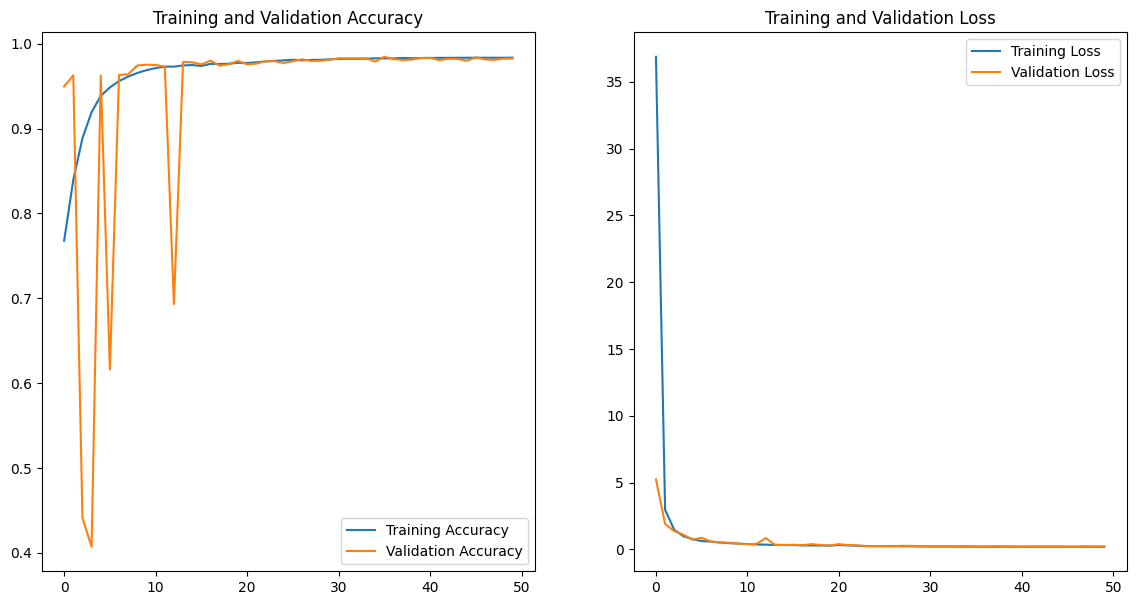

In [17]:
# Plot results
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [35]:
# Calculate F1 Score
train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

# Print metrics including F1 Score
print(f"{'Metric':<20}{'Train':>12}{'Validation':>12}{'Test':>12}")
print(f"{'-'*50}")
print(f"{'Loss:':<20}{train_loss:>12.4f}{val_loss:>12.4f}{test_loss:>12.4f}")
print(f"{'Accuracy:':<20}{train_acc:>12.4f}{val_acc:>12.4f}{test_acc:>12.4f}")
print(f"{'Precision:':<20}{train_precision:>12.4f}{val_precision:>12.4f}{test_precision:>12.4f}")
print(f"{'Recall:':<20}{train_recall:>12.4f}{val_recall:>12.4f}{test_recall:>12.4f}")
print(f"{'Dice Coefficient:':<20}{train_dice_coef:>12.4f}{val_dice_coef:>12.4f}{test_dice_coef:>12.4f}")
print(f"{'IoU Metric:':<20}{train_iou:>12.4f}{val_iou:>12.4f}{test_iou:>12.4f}")
print(f"{'F1 Score:':<20}{train_f1:>12.4f}{val_f1:>12.4f}{test_f1:>12.4f}")

Metric                     Train  Validation        Test
--------------------------------------------------
Loss:                     0.2077      0.2138      0.2092
Accuracy:                 0.9842      0.9832      0.9788
Precision:                0.8809      0.8767      0.8705
Recall:                   0.8088      0.8021      0.7616
Dice Coefficient:         0.7923      0.7862      0.7899
IoU Metric:               0.6668      0.6563      0.6501
F1 Score:                 0.8433      0.8377      0.8124


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━

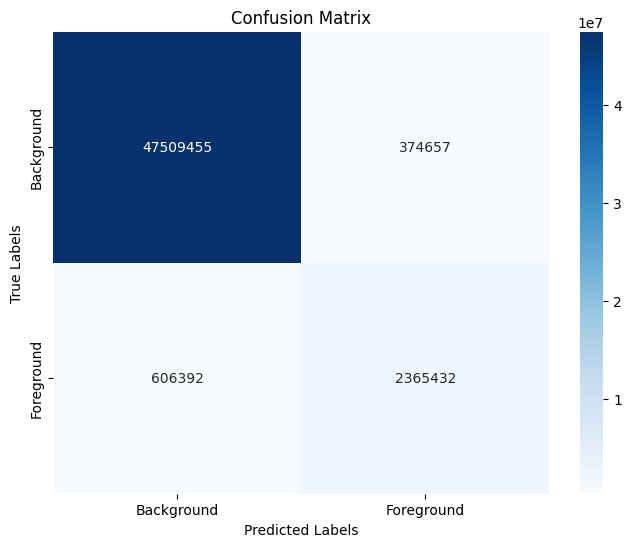

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model_on_test(test_dataset, model):
    all_true_masks = []
    all_pred_masks = []

    # Iterate through the test dataset
    for images, true_masks in test_dataset:
        # Predict masks
        preds = model.predict(images)
        preds = tf.math.round(preds)  # Round predictions to binary (0 or 1)

        # Convert tensors to numpy arrays and flatten them
        true_masks_np = tf.squeeze(true_masks).numpy().astype(np.uint8).flatten()
        preds_np = tf.squeeze(preds).numpy().astype(np.uint8).flatten()

        # Append to lists
        all_true_masks.append(true_masks_np)
        all_pred_masks.append(preds_np)

    # Flatten the lists
    all_true_masks = np.concatenate(all_true_masks)
    all_pred_masks = np.concatenate(all_pred_masks)

    # Generate classification report
    report = classification_report(all_true_masks, all_pred_masks, target_names=['Background', 'Foreground'])
    cm = confusion_matrix(all_true_masks, all_pred_masks)

    print("\nClassification Report:\n", report)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Foreground'], yticklabels=['Background', 'Foreground'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

evaluate_model_on_test(test_dataset, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


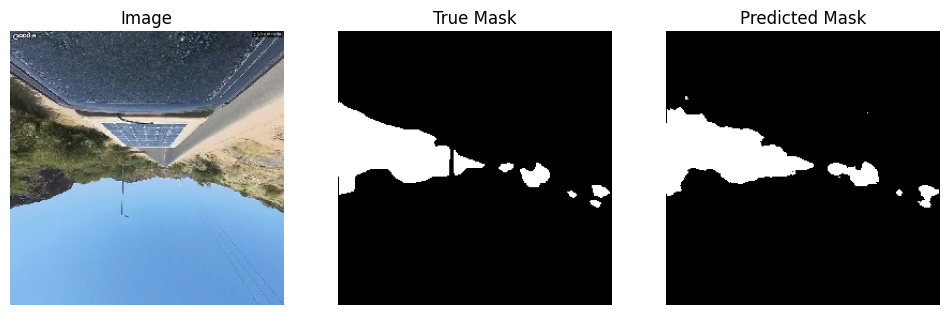

In [37]:
import numpy as np

def create_mask(pred_mask):

    pred_mask = np.squeeze(pred_mask)  
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  
    return pred_mask
import matplotlib.pyplot as plt

def display(images):
    plt.figure(figsize=(12, 6))
    
    titles = ['Image', 'True Mask', 'Predicted Mask']
    
    for i, img in enumerate(images):
        plt.subplot(1, 3, i + 1)
        plt.title(titles[i])
        img_np = img.numpy() if hasattr(img, 'numpy') else img
        plt.imshow(np.squeeze(img_np), cmap='gray')  
        plt.axis('off')
    
    plt.show()
def show_predictions(dataset, num=1):

    for image, mask in dataset.take(num):
        image_np = image.numpy()
        mask_np = mask.numpy()
        
        pred_mask = model.predict(image_np)
        pred_mask_np = create_mask(pred_mask[0])
        
        display([image_np[0], mask_np[0], pred_mask_np])
show_predictions(train_dataset, num=1)



In [38]:
model.save('/kaggle/working/Fpspnet_model.h5')
model.save('/kaggle/working/Fpspnet_model.keras')